Si ModuleNotFoundError: No module named 'tqdm' faire !pip install tqdm dans une cellule code

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
from tqdm import tqdm
import time
import GPUtil
import psutil

In [2]:
TRAIN_PATH = "../dataset/seg_train"
TEST_PATH  = "../dataset/seg_test"

In [3]:
MAX_FEATURES = 1500   # ORB keypoints
K = 300               # taille du vocabulaire visuel

In [4]:
class PerformanceTracker:
    def __init__(self):
        self.start_time = None
        self.logs = {}

    def start(self, name):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)
        self.mem_start = psutil.virtual_memory().used

    def stop(self, name):
        elapsed = time.time() - self.start_time
        cpu = psutil.cpu_percent(interval=None)
        mem = psutil.virtual_memory().used
        self.logs[name] = {
            "time_sec": elapsed,
            "cpu_percent": cpu,
            "ram_mb": mem / 1024**2
        }
        print(f"[{name}] Time: {elapsed:.1f}s | CPU: {cpu}% | RAM: {mem/1024**2:.0f} MB")

In [5]:
def load_images(folder_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            labels.append(label)

    return image_paths, labels, class_names


train_paths, train_labels, class_names = load_images(TRAIN_PATH)
test_paths, test_labels, _ = load_images(TEST_PATH)

print("Classes :", class_names)
print("Train :", len(train_paths))
print("Test :", len(test_paths))


Classes : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train : 14034
Test : 3000


In [6]:
orb = cv2.ORB_create(
    nfeatures=MAX_FEATURES,
    scaleFactor=1.2,
    nlevels=8
)

In [8]:
def extract_orb(paths, labels):
    descriptors = []
    valid_labels = []

    for path, label in tqdm(zip(paths, labels), total=len(paths)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
            valid_labels.append(label)

    return descriptors, np.array(valid_labels)



In [9]:
tracker = PerformanceTracker()

tracker.start("ORB extraction (train)")
train_des, y_train = extract_orb(train_paths, train_labels)
test_des,  y_test  = extract_orb(test_paths,  test_labels)
tracker.stop("ORB extraction (train)")

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 99.22it/s]

[ORB extraction (train)] Time: 158.2s | CPU: 17.5% | RAM: 7521 MB


In [10]:
all_train_des = np.vstack(train_des)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2000,   # plus gros batch
    random_state=42,
    n_init=10
)

tracker.start("KMeans vocab")
kmeans.fit(all_train_des)
tracker.stop("KMeans vocab")

print("Vocabulaire visuel créé :", K)

[KMeans vocab] Time: 20.5s | CPU: 41.6% | RAM: 5901 MB
Vocabulaire visuel créé : 300


In [11]:
def build_histograms(des_list, kmeans, k):
    X = np.zeros((len(des_list), k))
    for i, des in enumerate(des_list):
        words = kmeans.predict(des)
        for w in words:
            X[i, w] += 1
    norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
    return X / norm


tracker.start("BoVW histograms")
X_train = build_histograms(train_des, kmeans, K)
X_test = build_histograms(test_des, kmeans, K)
tracker.stop("BoVW histograms")


print(X_train.shape, X_test.shape)

[BoVW histograms] Time: 16.2s | CPU: 37.5% | RAM: 6088 MB
(14015, 300) (2997, 300)


In [12]:
svm = SVC(
    kernel='rbf',
    C=50,
    gamma=0.005,
    decision_function_shape='ovo'
)

tracker.start("SVM training")
svm.fit(X_train, y_train)
tracker.stop("SVM training")


[SVM training] Time: 32.6s | CPU: 16.9% | RAM: 6160 MB


In [13]:
y_pred = svm.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy : 0.4881548214881548

Rapport de classification :

              precision    recall  f1-score   support

   buildings       0.43      0.38      0.40       437
      forest       0.59      0.74      0.66       474
     glacier       0.45      0.43      0.44       552
    mountain       0.48      0.45      0.46       524
         sea       0.58      0.41      0.48       509
      street       0.41      0.53      0.47       501

    accuracy                           0.49      2997
   macro avg       0.49      0.49      0.48      2997
weighted avg       0.49      0.49      0.48      2997



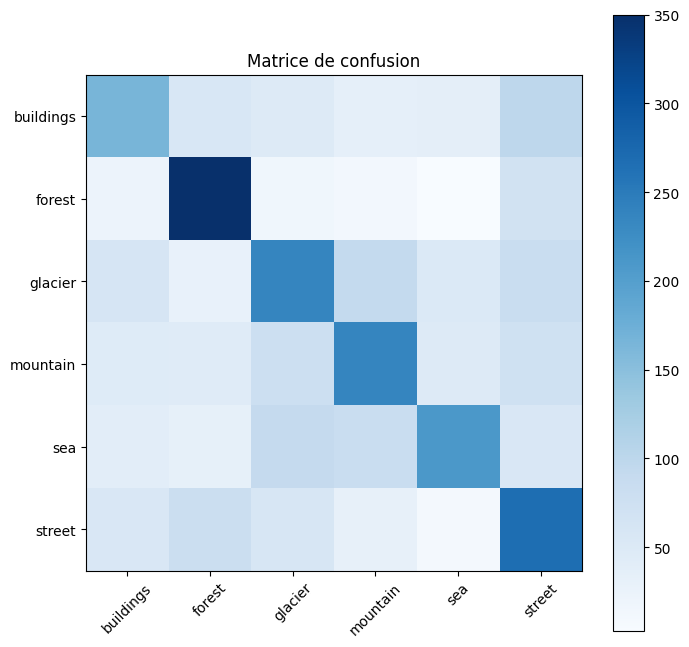

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap='Blues')
plt.title("Matrice de confusion")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.show()


In [15]:
output_dir = "checkpoints_ORB"
os.makedirs(output_dir, exist_ok=True)

In [16]:
joblib.dump(svm, os.path.join(output_dir, "svm_bovw_orb_Intel.pkl"))
joblib.dump(kmeans, os.path.join(output_dir, "kmeans_vocab_Intel.pkl"))
print("Modèle sauvegardé")

Modèle sauvegardé


### CONCLUSION
L’utilisation d’ORB et du Bag of Visual Words pour la classification des images du jeu de données Intel a mis en évidence les limites des approches basées sur des descripteurs locaux dans un contexte de scènes naturelles variées. La diversité des textures et des structures présentes dans les images rend la représentation BoVW peu discriminante.

En outre, le temps de calcul lié à l’extraction des descripteurs et au clustering KMeans sur CPU s’est avéré élevé, sans amélioration significative des résultats. Ce déséquilibre entre coût computationnel et performance a conduit à écarter cette méthode.